In [1]:
# load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import requests
from urllib.request import urlopen
import json
from shapely import wkt
import matplotlib.pyplot as plt
%matplotlib inline

# Crime

### Load Crime Data

In [2]:
# load data into geopandas dataframe
crime = gpd.read_file("https://opendata.arcgis.com/datasets/716338a41410457bb415a4bae2b2ad3e_0.geojson", low_memory=False)

# confirm load
crime.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# check column names - makes copying text for later steps easier
print(list(crime.columns.values))

['Index_', 'event_unique_id', 'Division', 'occurrencedate', 'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [4]:
# look at dataframe
crime.shape

(281692, 29)

In [5]:
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 281692 entries, 0 to 281691
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Index_               281692 non-null  int64   
 1   event_unique_id      281692 non-null  object  
 2   Division             281692 non-null  object  
 3   occurrencedate       281692 non-null  object  
 4   reporteddate         281692 non-null  object  
 5   location_type        281692 non-null  object  
 6   premises_type        281692 non-null  object  
 7   ucr_code             281692 non-null  int64   
 8   ucr_ext              281692 non-null  int64   
 9   offence              281692 non-null  object  
 10  reportedyear         281692 non-null  int64   
 11  reportedmonth        281692 non-null  object  
 12  reportedday          281692 non-null  int64   
 13  reporteddayofyear    281692 non-null  int64   
 14  reporteddayofweek    281692 non-null  object

In [6]:
crime.head()

,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,110,GO-20141625305,D23,2014-03-02T05:00:00,2014-03-02T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,1430,100,Assault,...,61,Sunday,8,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
1,188,GO-20141272968,D23,2013-12-24T05:00:00,2014-01-03T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,1610,200,Robbery - Mugging,...,358,Tuesday,22,Robbery,1,West Humber-Clairville,-79.600701,43.731834,2,POINT (-79.60070 43.73183)
2,287,GO-20141284361,D23,2013-01-05T05:00:00,2014-01-05T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,1430,100,Assault,...,5,Saturday,4,Assault,1,West Humber-Clairville,-79.600794,43.686423,3,POINT (-79.60079 43.68642)
3,384,GO-20141292177,D23,2013-12-31T05:00:00,2014-01-06T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2120,200,B&E,...,365,Tuesday,21,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642,4,POINT (-79.60388 43.74364)
4,438,GO-20141297201,D23,2014-01-03T05:00:00,2014-01-07T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2120,200,B&E,...,3,Friday,10,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,5,POINT (-79.58644 43.69711)


### Reduce Crime Data

In [7]:
# Data review

# 1. crime types - 2 fields
    # offence and MCI fields - from documentation, we know that offence is a non-standardized open field, whereas MCI is categorized
    # we will drop offence and keep MCI
    
# 2. neighbourhood and location - 5 fields
    # Hood_ID and Neighbourhood fields are duplicates, but should both be left in for fleixbility in matching with neighoburhood polygons later
        # documentation indicates that for locations identified outside the city of Toronto limits or as invalidated locations
        # the division/neighbourhood designation will be ‘NSA’ to indicate ‘Not Specified Area.’
        # we will identify and delete 'NSA' values as we are only concerned with occurences with identifiable locations
    # Lat, Lon, Geometry fields
        #we will check lat and long to see if there are outliers to remove, then we will delete them
    
# 3. cateogrical fields - 4 fields
    # location_type, premises_type, MCI, and Neighbourhood fields are all categorical data as indicated in the documentation
    # location_type is too detailed for our purposes
    # we will delete location_type and keep rest
    
# 4. ids - 2 fields
    # event_unique_id and ObjectId fields seem to both be unique values, but they are different data types
    # documentation suggests that occurences with multiple types of crimes will show up as multiple entries
    # therefore, one of these fields will have multiple entries and the other will have unique values - we will need to confirm differences

# 5. dates - 7 fields
    # occurrencedate, occurrenceyear, occurrencemonth, occurrenceday, occurrencedayofyear, occurrencedayofweek, and occurrencehour fields
    # occurencedate is generalized and is sufficient for our purposes
    # we will keep occurrencedate, occurrenceyear, occurrencemonth, occurrenceday for now and delete the rest

In [8]:
# Clean 1, 2, 5 and drop columns we don't need
cols2drop = ['Index_', 'Division', 'reporteddate', 'location_type', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 
             'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour']
for col in crime.columns:
    if col in cols2drop:
        crime.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
crime.shape

(281692, 13)

In [9]:
# 16 columns removed
# check column names again - makes copying text for later steps easier
print(list(crime.columns.values))

['event_unique_id', 'occurrencedate', 'premises_type', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [10]:
# let's take a quick peek at crime by year
crime['occurrenceyear'].value_counts()

2019    39912
2018    37408
2017    35484
2020    34866
2021    33685
2016    33596
2015    32910
2014    32459
2013      594
2012      182
2011      128
2010       96
0          95
2009       71
2008       42
2007       35
2004       26
2005       24
2000       22
2001       20
2003       14
2002       12
2006       11
Name: occurrenceyear, dtype: int64

In [11]:
# there appears to be a big change in crime data between 2013 and 2014 - a jump by 30 thousand a year!
# data from 2014 onwards appears to be similar and represents over 250,000 of the 281,692 entries in this dataset
# it is not clear why this is the case - perhaps due to a change in tracking or recording practices
# in order to ensure our analysis is not skewed, we will delete all occurences from 2013 or earlier
crime = crime[crime['occurrenceyear'] > 2013]

# confirm reduced dataframe
crime.shape

(280320, 13)

In [12]:
# appox 1300 crime events removed
# let's take another look at crime by year
crime['occurrenceyear'].value_counts()

2019    39912
2018    37408
2017    35484
2020    34866
2021    33685
2016    33596
2015    32910
2014    32459
Name: occurrenceyear, dtype: int64

In [13]:
## LOCAL ONLY

# save reduced data locally
path = os.path.join('data','raw')
fn = 'crimeData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
crime.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: crimeData.csv.gz
Done.


### Clean Crime Data

In [14]:
# have a look at data
crime.head(10)

,event_unique_id,occurrencedate,premises_type,occurrenceyear,occurrencemonth,occurrenceday,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,GO-20141625305,2014-03-02T05:00:00,House,2014,March,2,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
4,GO-20141297201,2014-01-03T05:00:00,Commercial,2014,January,3,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,5,POINT (-79.58644 43.69711)
5,GO-20141302953,2014-01-08T05:00:00,Commercial,2014,January,8,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,6,POINT (-79.58493 43.67834)
6,GO-20141304312,2014-01-08T05:00:00,House,2014,January,8,Break and Enter,1,West Humber-Clairville,-79.620043,43.722990,7,POINT (-79.62004 43.72299)
7,GO-20141303907,2014-01-06T05:00:00,Commercial,2014,January,6,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,8,POINT (-79.58493 43.67834)
9,GO-20141319035,2014-01-10T05:00:00,House,2014,January,10,Break and Enter,1,West Humber-Clairville,-79.624434,43.728138,10,POINT (-79.62443 43.72814)
10,GO-20141328884,2014-01-12T05:00:00,Other,2014,January,12,Assault,1,West Humber-Clairville,-79.618214,43.732364,11,POINT (-79.61821 43.73236)
11,GO-20141332021,2014-01-12T05:00:00,Apartment,2014,January,12,Assault,1,West Humber-Clairville,-79.602267,43.755689,12,POINT (-79.60227 43.75569)
12,GO-20141332021,2014-01-12T05:00:00,Apartment,2014,January,12,Assault,1,West Humber-Clairville,-79.602267,43.755689,13,POINT (-79.60227 43.75569)
13,GO-20141332404,2014-01-12T05:00:00,Outside,2014,January,12,Assault,1,West Humber-Clairville,-79.616890,43.723754,14,POINT (-79.61689 43.72375)


In [15]:
# as occurencedate is a timestamp, we will keep this and remove occurenceyear, occurencemonth, and occurence day
cols2drop2 = ['occurrenceyear', 'occurrencemonth', 'occurrenceday']
for col in crime.columns:
    if col in cols2drop2:
        crime.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
crime.shape

(280320, 10)

In [16]:
# remove nulls and nans
# count nulls by columns to identify if there are any problems
crime.isnull().sum(axis=0).sort_values(ascending=False)

geometry           0
ObjectId           0
Lat                0
Long               0
Neighbourhood      0
Hood_ID            0
MCI                0
premises_type      0
occurrencedate     0
event_unique_id    0
dtype: int64

In [17]:
# count nulls by rows
crime.isnull().sum(axis=1).sort_values(ascending=False)

281691    0
93861     0
93855     0
93856     0
93857     0
         ..
187684    0
187683    0
187682    0
187681    0
0         0
Length: 280320, dtype: int64

In [18]:
# no null values - great!
# now count nans by columns
crime.isna().sum(axis=0).sort_values(ascending=False)

geometry           0
ObjectId           0
Lat                0
Long               0
Neighbourhood      0
Hood_ID            0
MCI                0
premises_type      0
occurrencedate     0
event_unique_id    0
dtype: int64

In [19]:
# count nans by rows
crime.isna().sum(axis=1).sort_values(ascending=False)

281691    0
93861     0
93855     0
93856     0
93857     0
         ..
187684    0
187683    0
187682    0
187681    0
0         0
Length: 280320, dtype: int64

In [20]:
# no nans - great!

# Clean 2 - remove ‘NSA’ values from Hood_ID and Neighbourhood fields
# we will identify and delete these as we are only concerned with occurences with identifiable locations
crime.loc[crime['Hood_ID'] == 'NSA']

,event_unique_id,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
277000,GO-2016123990,2016-01-20T05:00:00,Other,Assault,NSA,NSA,0.000000,0.000000,277001,POINT (0.00000 0.00000)
277001,GO-2016134961,2016-01-23T05:00:00,Outside,Assault,NSA,NSA,0.000000,0.000000,277002,POINT (0.00000 0.00000)
277002,GO-2016137475,2016-01-23T05:00:00,Apartment,Assault,NSA,NSA,-79.747735,43.690595,277003,POINT (-79.74773 43.69059)
277003,GO-2016137475,2016-01-23T05:00:00,Apartment,Assault,NSA,NSA,-79.747735,43.690595,277004,POINT (-79.74773 43.69059)
277004,GO-2016139799,2016-01-24T05:00:00,Commercial,Assault,NSA,NSA,0.000000,0.000000,277005,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...
281687,GO-20212225907,2021-10-22T04:00:00,House,Break and Enter,NSA,NSA,-79.245151,43.838010,281688,POINT (-79.24515 43.83801)
281688,GO-20212226010,2021-10-08T04:00:00,House,Break and Enter,NSA,NSA,-79.286862,43.847594,281689,POINT (-79.28686 43.84759)
281689,GO-20212238042,2021-11-20T05:00:00,Apartment,Assault,NSA,NSA,-79.533763,43.931775,281690,POINT (-79.53376 43.93177)
281690,GO-20212240466,2021-11-18T05:00:00,House,Assault,NSA,NSA,0.000000,0.000000,281691,POINT (0.00000 0.00000)


In [21]:
# it seems that when 'Hood_ID' == NSA, 'Neighbourhood' is also NSA, let's check to see if we get the same results
crime.loc[crime['Neighbourhood'] == 'NSA']

,event_unique_id,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
277000,GO-2016123990,2016-01-20T05:00:00,Other,Assault,NSA,NSA,0.000000,0.000000,277001,POINT (0.00000 0.00000)
277001,GO-2016134961,2016-01-23T05:00:00,Outside,Assault,NSA,NSA,0.000000,0.000000,277002,POINT (0.00000 0.00000)
277002,GO-2016137475,2016-01-23T05:00:00,Apartment,Assault,NSA,NSA,-79.747735,43.690595,277003,POINT (-79.74773 43.69059)
277003,GO-2016137475,2016-01-23T05:00:00,Apartment,Assault,NSA,NSA,-79.747735,43.690595,277004,POINT (-79.74773 43.69059)
277004,GO-2016139799,2016-01-24T05:00:00,Commercial,Assault,NSA,NSA,0.000000,0.000000,277005,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...
281687,GO-20212225907,2021-10-22T04:00:00,House,Break and Enter,NSA,NSA,-79.245151,43.838010,281688,POINT (-79.24515 43.83801)
281688,GO-20212226010,2021-10-08T04:00:00,House,Break and Enter,NSA,NSA,-79.286862,43.847594,281689,POINT (-79.28686 43.84759)
281689,GO-20212238042,2021-11-20T05:00:00,Apartment,Assault,NSA,NSA,-79.533763,43.931775,281690,POINT (-79.53376 43.93177)
281690,GO-20212240466,2021-11-18T05:00:00,House,Assault,NSA,NSA,0.000000,0.000000,281691,POINT (0.00000 0.00000)


In [22]:
# they match! we will delete these
crime = crime[crime.Hood_ID != 'NSA']
crime = crime[crime.Neighbourhood != 'NSA']

# confirm reduced dataframe
crime.shape

(275771, 10)

In [23]:
# count unique values of neighbourhood fields
count1 = crime.Hood_ID.nunique()
count2 = crime.Neighbourhood.nunique()
print(count1)
print(count2)

140
140


In [24]:
# they match!

# Clean 2 - from above, we can see some POINTs are (0,0) 
# let's check lat and long fields for outliers
location = crime[['Long', 'Lat']]
location.describe()

,Long,Lat
count,275771.000000,275771.000000
mean,-79.316305,43.662853
std,2.517174,1.385511
min,-79.639225,0.000000
25%,-79.471427,43.660791
50%,-79.393820,43.700160
75%,-79.324129,43.751394
max,0.000000,43.853752


In [25]:
# min in the lat field is showing as 0 which is definitely not in Toronto

# let's check how many values are equal to 0
print((crime['Lat'] == 0).sum())

# vs. all values
print((crime['Lat']).count())

277
275771


In [26]:
# delete 277 crime events outside Toronto
crime = crime[crime.Lat != 0]

# check values again
location2 = crime[['Long', 'Lat']]
location2.describe()

,Long,Lat
count,275494.000000,275494.000000
mean,-79.396055,43.706754
std,0.103366,0.052624
min,-79.639225,43.587092
25%,-79.471439,43.660816
50%,-79.393889,43.700313
75%,-79.324574,43.751440
max,-79.123062,43.853752


In [27]:
# that fixed the problem!

# we can now delete Long and Lat columns
cols2drop3 = ['Long', 'Lat']

for col in crime.columns:
    if col in cols2drop3:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))

['event_unique_id', 'occurrencedate', 'premises_type', 'MCI', 'Hood_ID', 'Neighbourhood', 'ObjectId', 'geometry']


In [28]:
# check dataframe again
crime.shape

(275494, 8)

In [29]:
# Clean 4 - we have 275494 crime events, let's check count of unique values of id fields compared to rows
count3 = crime.event_unique_id.nunique()
count4 = crime.ObjectId.nunique()
print(count3)
print(count4)

239948
275494


In [30]:
# the event_unique_id field has duplicate values, whereas the ObjectID field has a unique value for every row
# as per documentation one event can have mutliple crime types - for example, a single event could have both an assault and a theft
# for our purposes, we want to ensure we count each crime type seperately
# we will delete the event_unique_id field and keep the ObjectId field
cols2drop4 = ['event_unique_id']

for col in crime.columns:
    if col in cols2drop4:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))

['occurrencedate', 'premises_type', 'MCI', 'Hood_ID', 'Neighbourhood', 'ObjectId', 'geometry']


In [31]:
# check dataframe again
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275494 entries, 0 to 277185
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   occurrencedate  275494 non-null  object  
 1   premises_type   275494 non-null  object  
 2   MCI             275494 non-null  object  
 3   Hood_ID         275494 non-null  object  
 4   Neighbourhood   275494 non-null  object  
 5   ObjectId        275494 non-null  int64   
 6   geometry        275494 non-null  geometry
dtypes: geometry(1), int64(1), object(5)
memory usage: 16.8+ MB


In [32]:
# convert data types
for c in ['premises_type','MCI','Neighbourhood']:
    crime[c] = crime[c].astype('category')
for c in ['Hood_ID']:
    crime[c] = crime[c].astype('int')

# convert to datetime
crime['TimeSeries'] = pd.to_datetime(crime.occurrencedate.values, infer_datetime_format=True)

In [33]:
# confirm changes
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275494 entries, 0 to 277185
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   occurrencedate  275494 non-null  object        
 1   premises_type   275494 non-null  category      
 2   MCI             275494 non-null  category      
 3   Hood_ID         275494 non-null  int64         
 4   Neighbourhood   275494 non-null  category      
 5   ObjectId        275494 non-null  int64         
 6   geometry        275494 non-null  geometry      
 7   TimeSeries      275494 non-null  datetime64[ns]
dtypes: category(3), datetime64[ns](1), geometry(1), int64(2), object(1)
memory usage: 13.7+ MB


In [34]:
crime.TimeSeries.head()

0   2014-03-02 05:00:00
4   2014-01-03 05:00:00
5   2014-01-08 05:00:00
6   2014-01-08 05:00:00
7   2014-01-06 05:00:00
Name: TimeSeries, dtype: datetime64[ns]

### Enrich Crime Data

In [35]:
# as we are completing an analysis of the impact of COVID-19 lockdowns on crime, we will add an additonal column for lockdown information
# from research we know that Toronto had three lockdowns as follows:

lockdowns = {'first':['2020-03-23','2020-07-31'],
             'second':['2020-11-23','2021-03-08'],
             'third':['2021-04-08','2021-06-02']}

for k, (s,e) in lockdowns.items():
    crime.loc[crime['TimeSeries'].between(s,e), 'lockdownNo'] = k

crime.head()

,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,TimeSeries,lockdownNo
0,2014-03-02T05:00:00,House,Assault,1,West Humber-Clairville,1,POINT (-79.59033 43.73401),2014-03-02 05:00:00,NaN
4,2014-01-03T05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,5,POINT (-79.58644 43.69711),2014-01-03 05:00:00,NaN
5,2014-01-08T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,6,POINT (-79.58493 43.67834),2014-01-08 05:00:00,NaN
6,2014-01-08T05:00:00,House,Break and Enter,1,West Humber-Clairville,7,POINT (-79.62004 43.72299),2014-01-08 05:00:00,NaN
7,2014-01-06T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,8,POINT (-79.58493 43.67834),2014-01-06 05:00:00,NaN


In [36]:
# replace NaN values in lockdownNum field with NONE (no lockdown)
crime['lockdownNo'] = crime['lockdownNo'].fillna('none')

# check revised number of occurrences by lockdownNum
crime.lockdownNo.value_counts()

none      250721
first      11542
second      8412
third       4819
Name: lockdownNo, dtype: int64

In [37]:
# create a binary lockdown column based on lockdownNum column where 1 = in lockdown, and 0 = not in lockdown
crime['lockdownStatus'] = ['1' if x == 'first' else '1' if x == 'second' else '1' if x == 'third' else '0' for x in crime['lockdownNo']]

#confirm new column
crime.head()

,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,TimeSeries,lockdownNo,lockdownStatus
0,2014-03-02T05:00:00,House,Assault,1,West Humber-Clairville,1,POINT (-79.59033 43.73401),2014-03-02 05:00:00,none,0
4,2014-01-03T05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,5,POINT (-79.58644 43.69711),2014-01-03 05:00:00,none,0
5,2014-01-08T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,6,POINT (-79.58493 43.67834),2014-01-08 05:00:00,none,0
6,2014-01-08T05:00:00,House,Break and Enter,1,West Humber-Clairville,7,POINT (-79.62004 43.72299),2014-01-08 05:00:00,none,0
7,2014-01-06T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,8,POINT (-79.58493 43.67834),2014-01-06 05:00:00,none,0


In [38]:
# check datatypes
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275494 entries, 0 to 277185
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   occurrencedate  275494 non-null  object        
 1   premises_type   275494 non-null  category      
 2   MCI             275494 non-null  category      
 3   Hood_ID         275494 non-null  int64         
 4   Neighbourhood   275494 non-null  category      
 5   ObjectId        275494 non-null  int64         
 6   geometry        275494 non-null  geometry      
 7   TimeSeries      275494 non-null  datetime64[ns]
 8   lockdownNo      275494 non-null  object        
 9   lockdownStatus  275494 non-null  object        
dtypes: category(3), datetime64[ns](1), geometry(1), int64(2), object(3)
memory usage: 17.9+ MB


In [39]:
# delete occurrencedate as it is no longer needed
cols2drop5 = ['occurrencedate']
for col in crime.columns:
    if col in cols2drop5:
        crime.drop(col, inplace=True, axis=1)

# convert datatypes
for c in ['lockdownNo']:
    crime[c] = crime[c].astype('category')
for c in ['lockdownStatus']:
    crime[c] = crime[c].astype('int')

# confirm changes
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275494 entries, 0 to 277185
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   premises_type   275494 non-null  category      
 1   MCI             275494 non-null  category      
 2   Hood_ID         275494 non-null  int64         
 3   Neighbourhood   275494 non-null  category      
 4   ObjectId        275494 non-null  int64         
 5   geometry        275494 non-null  geometry      
 6   TimeSeries      275494 non-null  datetime64[ns]
 7   lockdownNo      275494 non-null  category      
 8   lockdownStatus  275494 non-null  int64         
dtypes: category(4), datetime64[ns](1), geometry(1), int64(3)
memory usage: 13.9 MB


In [40]:
# random check of data frame
crime.sample(frac=0.5)

,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,TimeSeries,lockdownNo,lockdownStatus
221919,Apartment,Assault,117,LAmoreaux,221920,POINT (-79.31927 43.79585),2016-01-05 05:00:00,none,0
174849,Outside,Auto Theft,84,Little Portugal,174850,POINT (-79.42596 43.64277),2017-09-03 04:00:00,none,0
107779,Commercial,Break and Enter,63,The Beaches,107780,POINT (-79.30574 43.66876),2020-11-03 05:00:00,none,0
107512,Outside,Assault,63,The Beaches,107513,POINT (-79.31255 43.66724),2021-07-01 04:00:00,none,0
182724,Apartment,Assault,88,High Park North,182725,POINT (-79.46818 43.65633),2021-03-18 04:00:00,none,0
...,...,...,...,...,...,...,...,...,...
199401,Apartment,Assault,99,Mount Pleasant East,199402,POINT (-79.38120 43.71021),2015-10-20 04:00:00,none,0
93150,Commercial,Break and Enter,52,Bayview Village,93151,POINT (-79.37425 43.77014),2015-04-28 04:00:00,none,0
270954,Apartment,Assault,137,Woburn,270955,POINT (-79.21101 43.76286),2019-04-06 04:00:00,none,0
224887,Outside,Auto Theft,118,Tam OShanter-Sullivan,224888,POINT (-79.29342 43.78212),2017-01-23 05:00:00,none,0


In [41]:
# NOTE: precison of geometry column is not consistent - some are 7 decimals, others are 14 decimals
# likely due to tying crime locations to nearest intersection rather than address
# we will leave precison as it is

### Save Cleaned Crime Data

In [42]:
# have a look at data
crime.head(10)

,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,TimeSeries,lockdownNo,lockdownStatus
0,House,Assault,1,West Humber-Clairville,1,POINT (-79.59033 43.73401),2014-03-02 05:00:00,none,0
4,Commercial,Break and Enter,1,West Humber-Clairville,5,POINT (-79.58644 43.69711),2014-01-03 05:00:00,none,0
5,Commercial,Theft Over,1,West Humber-Clairville,6,POINT (-79.58493 43.67834),2014-01-08 05:00:00,none,0
6,House,Break and Enter,1,West Humber-Clairville,7,POINT (-79.62004 43.72299),2014-01-08 05:00:00,none,0
7,Commercial,Theft Over,1,West Humber-Clairville,8,POINT (-79.58493 43.67834),2014-01-06 05:00:00,none,0
9,House,Break and Enter,1,West Humber-Clairville,10,POINT (-79.62443 43.72814),2014-01-10 05:00:00,none,0
10,Other,Assault,1,West Humber-Clairville,11,POINT (-79.61821 43.73236),2014-01-12 05:00:00,none,0
11,Apartment,Assault,1,West Humber-Clairville,12,POINT (-79.60227 43.75569),2014-01-12 05:00:00,none,0
12,Apartment,Assault,1,West Humber-Clairville,13,POINT (-79.60227 43.75569),2014-01-12 05:00:00,none,0
13,Outside,Assault,1,West Humber-Clairville,14,POINT (-79.61689 43.72375),2014-01-12 05:00:00,none,0


In [43]:
# have a look at dataframe
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275494 entries, 0 to 277185
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   premises_type   275494 non-null  category      
 1   MCI             275494 non-null  category      
 2   Hood_ID         275494 non-null  int64         
 3   Neighbourhood   275494 non-null  category      
 4   ObjectId        275494 non-null  int64         
 5   geometry        275494 non-null  geometry      
 6   TimeSeries      275494 non-null  datetime64[ns]
 7   lockdownNo      275494 non-null  category      
 8   lockdownStatus  275494 non-null  int64         
dtypes: category(4), datetime64[ns](1), geometry(1), int64(3)
memory usage: 13.9 MB


In [44]:
## LOCAL ONLY

# save crime as clean data
path = os.path.join('data','clean')
fn = 'crimeData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
crime.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: crimeData.csv.gz
Done.


In [46]:
## NOTE - categorical data not able to be saved as part of GPKG

# convert categorical data back to object
for c in ['premises_type', 'MCI', 'Neighbourhood', 'lockdownNo']:
    crime[c] = crime[c].astype('object')

In [47]:
## LOCAL ONLY

# save crime as a geodataframe

# Set save location
path = os.path.join('data','geo')
fn = 'crime.gpkg'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
print(f"Using '{fn}' as basis for saving data...")

crime.to_file(os.path.join(path,fn), driver='GPKG')
print("Done.")

Using 'crime.gpkg' as basis for saving data...
Done.


# COVID Cases

### Load COVID Data

In [48]:
# now let's look at the Covid case data
# open covid-19 case data into a pandas dataframe

url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64b54586-6180-4485-83eb-81e8fae3b8fe/resource/fff4ee65-3527-43be-9a8a-cb9401377dbc/download/COVID19%20cases.csv'
covid = pd.read_csv(url, low_memory=False)

# confirm load
covid.shape

(313961, 18)

In [49]:
# check dataframe
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313961 entries, 0 to 313960
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   _id                     313961 non-null  int64 
 1   Assigned_ID             313961 non-null  int64 
 2   Outbreak Associated     313961 non-null  object
 3   Age Group               313648 non-null  object
 4   Neighbourhood Name      305511 non-null  object
 5   FSA                     309377 non-null  object
 6   Source of Infection     313961 non-null  object
 7   Classification          313961 non-null  object
 8   Episode Date            313961 non-null  object
 9   Reported Date           313961 non-null  object
 10  Client Gender           313961 non-null  object
 11  Outcome                 313961 non-null  object
 12  Currently Hospitalized  313961 non-null  object
 13  Currently in ICU        313961 non-null  object
 14  Currently Intubated     313961 non-n

In [50]:
# check column names - makes copying text for later steps easier
print(list(covid.columns.values))

['_id', 'Assigned_ID', 'Outbreak Associated', 'Age Group', 'Neighbourhood Name', 'FSA', 'Source of Infection', 'Classification', 'Episode Date', 'Reported Date', 'Client Gender', 'Outcome', 'Currently Hospitalized', 'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']


In [51]:
# look at data
covid.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


### Reduce COVID Data

In [52]:
# drop columns we don't need
cols2drop6 = ['Outbreak Associated', 'Age Group', 'Source of Infection', 'Client Gender', 'Outcome', 'Currently Hospitalized', 
              'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
for col in covid.columns:
    if col in cols2drop6:
        covid.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313961 entries, 0 to 313960
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   _id                 313961 non-null  int64 
 1   Assigned_ID         313961 non-null  int64 
 2   Neighbourhood Name  305511 non-null  object
 3   FSA                 309377 non-null  object
 4   Classification      313961 non-null  object
 5   Episode Date        313961 non-null  object
 6   Reported Date       313961 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.8+ MB


In [53]:
# check column names again - makes copying text for later steps easier
print(list(covid.columns.values))

['_id', 'Assigned_ID', 'Neighbourhood Name', 'FSA', 'Classification', 'Episode Date', 'Reported Date']


In [54]:
## LOCAL ONLY

# save reduced data locally
path = os.path.join('data','raw')
fn = 'covidData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
covid.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: covidData.csv.gz
Done.


### Clean COVID Data

In [55]:
## LOCAL ONLY

# reload covid data
path = os.path.join('data','raw')
fn = 'covidData.csv.gz'
covid = pd.read_csv(os.path.join(path,fn), compression='gzip', low_memory=False)

# have a look at data
covid.head(10)

,_id,Assigned_ID,Neighbourhood Name,FSA,Classification,Episode Date,Reported Date
0,1,1,Willowdale East,M2N,CONFIRMED,2020-01-22,2020-01-23
1,2,2,Willowdale East,M2N,CONFIRMED,2020-01-21,2020-01-23
2,3,3,Parkwoods-Donalda,M3A,CONFIRMED,2020-02-05,2020-02-21
3,4,4,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-16,2020-02-25
4,5,5,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-20,2020-02-26
5,6,6,Newtonbrook West,M2R,CONFIRMED,2020-02-24,2020-02-27
6,7,7,Milliken,M1V,CONFIRMED,2020-02-20,2020-02-28
7,8,8,Willowdale West,M2N,CONFIRMED,2020-02-21,2020-03-04
8,9,9,Willowdale East,M2N,CONFIRMED,2020-02-29,2020-02-29
9,10,10,Henry Farm,M2J,CONFIRMED,2020-02-26,2020-03-01


In [56]:
# count nulls by columns to identify if there are any problems
covid.isnull().sum(axis=0).sort_values(ascending=False)

Neighbourhood Name    8450
FSA                   4584
Reported Date            0
Episode Date             0
Classification           0
Assigned_ID              0
_id                      0
dtype: int64

In [57]:
# count nulls by rows
covid.isnull().sum(axis=1).sort_values(ascending=False)

310636    2
273398    2
262762    2
267075    2
81869     2
         ..
206484    0
206485    0
206486    0
206487    0
0         0
Length: 313961, dtype: int64

In [58]:
# many null values
# let's look at remaining columns in more detail to see if we can drop more
covid.head()[['_id', 'Assigned_ID', 'Neighbourhood Name', 'FSA', 'Classification', 'Episode Date', 'Reported Date']]

,_id,Assigned_ID,Neighbourhood Name,FSA,Classification,Episode Date,Reported Date
0,1,1,Willowdale East,M2N,CONFIRMED,2020-01-22,2020-01-23
1,2,2,Willowdale East,M2N,CONFIRMED,2020-01-21,2020-01-23
2,3,3,Parkwoods-Donalda,M3A,CONFIRMED,2020-02-05,2020-02-21
3,4,4,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-16,2020-02-25
4,5,5,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-20,2020-02-26


In [59]:
# Data review
# 1. ids - 2 fields
    # the _id and Assigned_ID fields seem to be identical and have the same amount
    # however, documentation suggests Assigned_ID is from Toronto Public Health, not the database, and cases can disappear
    # based on this, we will delete Assigned_ID

# 2. Locations - 2 fields
    # the Neighbourhood Name and Forward Sortation Area (FSA) fields both can be used to geolocate the cases
    # documentation suggests that the FSA field and Census Tracts (CTs) were used to determine the Neighbourhood Name
    # documentation also mentions that neighbourhood information is missing for cases with missing postalcodes
    # for our purposes aggregate numbers are okay and we don't need to geolocate so we will drop both of these fields 

# 3. Status - 1 field
    # According to the documentation, the Classification field classifies cases as either confirmed or probable
    # as with above, for our purposes, aggregate numbers are okay, we will delete probable cases and keep confirmed
    
# 4. dates - 2 fields
    # we do not need both of these dates, so we will keep the reported date as an official record and drop the episode date
    # change reported date to reported_date for ease
    
# drop columns we don't need
cols2drop7 = ['Assigned_ID', 'Neighbourhood Name', 'FSA', 'Episode Date']
for col in covid.columns:
    if col in cols2drop7:
        covid.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313961 entries, 0 to 313960
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             313961 non-null  int64 
 1   Classification  313961 non-null  object
 2   Reported Date   313961 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.2+ MB


In [60]:
# check column names again - makes copying text for later steps easier
print(list(covid.columns.values))

['_id', 'Classification', 'Reported Date']


In [61]:
# count nulls by columns to identify if there are any problems
covid.isnull().sum(axis=0).sort_values(ascending=False)

Reported Date     0
Classification    0
_id               0
dtype: int64

In [62]:
# count nulls by rows
covid.isnull().sum(axis=1).sort_values(ascending=False)

313960    0
104656    0
104649    0
104650    0
104651    0
         ..
209306    0
209307    0
209308    0
209309    0
0         0
Length: 313961, dtype: int64

In [63]:
# no more nulls - perfect!
# check classification counts 
covid.Classification.value_counts()

CONFIRMED    303165
PROBABLE      10796
Name: Classification, dtype: int64

In [64]:
# remove PROBABLE cases, keep CONFIRMED cases
covid = covid[covid.Classification != 'PROBABLE']

# confirm reduced dataframe
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303165 entries, 0 to 313959
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             303165 non-null  int64 
 1   Classification  303165 non-null  object
 2   Reported Date   303165 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [65]:
# check counts
covid.Classification.value_counts()

CONFIRMED    303165
Name: Classification, dtype: int64

In [66]:
# rename reported date field
covid.rename(columns = {'Reported Date':'ReportedDate'}, inplace = True)

# confirm changes
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303165 entries, 0 to 313959
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             303165 non-null  int64 
 1   Classification  303165 non-null  object
 2   ReportedDate    303165 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [67]:
# the last thing we want to do is to get a summary count of all confirmed cases per day
casesperday = covid.groupby(['ReportedDate']).size().reset_index(name='CasesPerDay')
casesperday = casesperday.sort_values(by=['CasesPerDay'], ascending=False)
casesperday

,ReportedDate,CasesPerDay
676,2021-12-31,4393
675,2021-12-30,4381
674,2021-12-29,4068
677,2022-01-01,3528
673,2021-12-28,3420
...,...,...
6,2020-02-29,1
5,2020-02-28,1
4,2020-02-27,1
3,2020-02-26,1


In [68]:
# convert ReportedDate to datetime
casesperday['ReportedDate'] = pd.to_datetime(casesperday.ReportedDate.values, infer_datetime_format=True)

# confirm changes
casesperday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 676 to 2
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ReportedDate  785 non-null    datetime64[ns]
 1   CasesPerDay   785 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.4 KB


### Save Cleaned COVID Data

In [69]:
## LOCAL ONLY

# save cleaned covid case data
path = os.path.join('data','clean')
fn = 'covidData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
casesperday.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: covidData.csv.gz
Done.


# Key Dates

### Load Key Dates Data

In [70]:
## LOCAL ONLY

# now let's look at key dates
# load key dates data into a pandas dataframe

path = os.path.join('data','raw')
fn = 'keyDates.csv'
kd = pd.read_csv(os.path.join(path,fn), low_memory=False)

# have a look at data
kd.head(10)

,Date,Event,Lockdown,LockdownDates,KeyDates
0,2020-03-12,Ontario closes all public schools.,None,0,1
1,2020-03-13,Toronto’s universities cancel all in-person cl...,None,0,1
2,2020-03-15,Ontario places all non-essential care and elec...,None,0,1
3,2020-03-17,Ontario declares a provincial state of emergen...,None,0,1
4,2020-03-18,Canada closes its international border and Can...,None,0,1
5,2020-03-20,"Air Canada, Westjet, Air Transat and Greyhound...",None,0,0
6,2020-03-23,Ontario orders emergency closure of all non-es...,First,1,1
7,2020-03-24,"Pursuant to the declared emergency, a new orde...",First,0,0
8,2020-03-25,Toronto closes all city-owned playgrounds and ...,First,0,1
9,2020-03-27,Travellers returning to Ontario are required t...,First,0,0


In [71]:
# check dataframe
kd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           115 non-null    object
 1   Event          115 non-null    object
 2   Lockdown       115 non-null    object
 3   LockdownDates  115 non-null    int64 
 4   KeyDates       115 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.6+ KB


In [72]:
# Data review

# 1. dates - 3 fields
    # Date field - refers to date of event (see keydates) - will convert to datetime and change to eventDate
    # LockdownDates - is binary - refers to the dates the lockdowns began and ended - will be used for visualization (red line) - will leave as int
    # KeyDates - is binary - refers to key events for headlines in the visualization - will leave as int - change to keyEvents
    
# 2. Event - 1 field
    # can be used as headlines or scrolling tickers for the visualization
    # will change name to eventHeadline
    
# 3. cateogrical fields - 1 fields
    # Lockdown field - represents which lockdown
    # we will convert this to category and change to lockdownNo

### Clean Key Dates

In [73]:
# rename columns
kd.rename(columns = {'Date':'eventDate', 'Event':'eventHeadline', 'Lockdown':'lockdownNo', 'LockdownDates':'lockdownDates', 'KeyDates':'keyEvents'}, inplace = True)

# confirm changes
kd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   eventDate      115 non-null    object
 1   eventHeadline  115 non-null    object
 2   lockdownNo     115 non-null    object
 3   lockdownDates  115 non-null    int64 
 4   keyEvents      115 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.6+ KB


In [74]:
# convert datatypes
for c in ['lockdownNo']:
    kd[c] = kd[c].astype('category')
    
# confirm conversion to categories
kd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   eventDate      115 non-null    object  
 1   eventHeadline  115 non-null    object  
 2   lockdownNo     115 non-null    category
 3   lockdownDates  115 non-null    int64   
 4   keyEvents      115 non-null    int64   
dtypes: category(1), int64(2), object(2)
memory usage: 4.0+ KB


### Save Cleaned Key Dates

In [75]:
## LOCAL ONLY

# save cleaned key dates data
path = os.path.join('data','clean')
fn = 'keyDates.csv'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
kd.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Writing to: keyDates.csv
Done.


# Neighbourhood Boundaries

### Load Neighbourhood data

In [76]:
# now let's look at the neighbourhood boundaries
# read in json file
tor_nbs = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/4def3f65-2a65-4a4f-83c4-b2a4aed72d46/resource/9ce32bd1-91ac-4422-925a-bdc256702756/download/Neighbourhoods%20-%20historical%20140.geojson')

# confirm load
tor_nbs.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2487173,26010508,None,93,93,Dovercourt-Wallace Emerson-Junction (93),Dovercourt-Wallace Emerson-Junction (93),None,None,17626305,"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,2487172,26010507,None,121,121,Oakridge (121),Oakridge (121),Neighbourhood Improvement Area,NIA,17626321,"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,2487171,26010506,None,110,110,Keelesdale-Eglinton West (110),Keelesdale-Eglinton West (110),Neighbourhood Improvement Area,NIA,17626337,"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,2487170,26010505,None,108,108,Briar Hill-Belgravia (108),Briar Hill-Belgravia (108),None,None,17626353,"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,2487111,26010446,None,45,45,Parkwoods-Donalda (45),Parkwoods-Donalda (45),None,None,17626369,"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


In [77]:
# check data
tor_nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   _id                  140 non-null    int64   
 1   AREA_ID              140 non-null    int64   
 2   AREA_ATTR_ID         140 non-null    int64   
 3   PARENT_AREA_ID       0 non-null      object  
 4   AREA_SHORT_CODE      140 non-null    int64   
 5   AREA_LONG_CODE       140 non-null    int64   
 6   AREA_NAME            140 non-null    object  
 7   AREA_DESC            140 non-null    object  
 8   CLASSIFICATION       140 non-null    object  
 9   CLASSIFICATION_CODE  140 non-null    object  
 10  OBJECTID             140 non-null    int64   
 11  geometry             140 non-null    geometry
dtypes: geometry(1), int64(6), object(5)
memory usage: 13.2+ KB


In [78]:
# check column names - makes copying text for later steps easier
print(list(tor_nbs.columns.values))

['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE', 'OBJECTID', 'geometry']


### Reduce Neighbourhood data

In [79]:
# drop columns we don't need - we only need to be able to match neighbourhood geography to Hood_ID and Neighbourhood columns within the crimeData table
cols2drop8 = ['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_LONG_CODE', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE', 'OBJECTID']
for col in tor_nbs.columns:
    if col in cols2drop8:
        tor_nbs.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
tor_nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   _id              140 non-null    int64   
 1   AREA_SHORT_CODE  140 non-null    int64   
 2   AREA_NAME        140 non-null    object  
 3   geometry         140 non-null    geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 4.5+ KB


In [80]:
# look at data
tor_nbs.head()

,_id,AREA_SHORT_CODE,AREA_NAME,geometry
0,1,93,Dovercourt-Wallace Emerson-Junction (93),"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,121,Oakridge (121),"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,110,Keelesdale-Eglinton West (110),"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,108,Briar Hill-Belgravia (108),"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,45,Parkwoods-Donalda (45),"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


### Clean Neighbourhood data

In [81]:
# data review

# 1 - area name field
    # we will rename this column to match the 'Neighbourhood' column of our crime data

# 2 - area code field
    # we will rename this column to match the 'Hood_ID' column of our crime data

In [82]:
# rename columns to match our crime data
tor_nbs.rename(columns={'AREA_NAME': 'Neighbourhood', 'AREA_SHORT_CODE':'Hood_ID'}, inplace=True)

# check to confirm changes
tor_nbs.head()

,_id,Hood_ID,Neighbourhood,geometry
0,1,93,Dovercourt-Wallace Emerson-Junction (93),"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,121,Oakridge (121),"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,110,Keelesdale-Eglinton West (110),"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,108,Briar Hill-Belgravia (108),"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,45,Parkwoods-Donalda (45),"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


In [83]:
# count how many neighbourhoods
tor_nbs.Hood_ID.nunique()

140

### Enrich Neighbourhood Data

In [84]:
# we want to add population data to our neighbourhoods so  we can calculate crimes rates

# load neighbourhood population
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/15a37448-b27e-44d2-9c2e-52e148c8894f/resource/82a63ca1-dcd3-46fa-a078-ba028b1cb8eb/download/wellbeing-toronto-population-total-2011-2016-and-age-groups-2016.xlsx'
pop = pd.read_excel(url, sheet_name='016 Pop_TotalChange')

# confirm load
pop.shape

(140, 5)

In [85]:
# look at data
pop.head()

,HoodID,Neighbourhood,Pop2016,Pop2011,PopChg11t16
0,1,West Humber-Clairville,33312,34100,-0.023109
1,2,Mount Olive-Silverstone-Jamestown,32954,32788,0.005063
2,3,Thistletown-Beaumond Heights,10360,10138,0.021898
3,4,Rexdale-Kipling,10529,10488,0.003909
4,5,Elms-Old Rexdale,9456,9550,-0.009843


In [86]:
# drop columns we don't need
cols2drop9 = ['Pop2011', 'PopChg11t16']
for col in pop.columns:
    if col in cols2drop9:
        pop.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   HoodID         140 non-null    int64 
 1   Neighbourhood  140 non-null    object
 2   Pop2016        140 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ KB


In [87]:
# rename HoodID to Hood_ID
pop.rename(columns={'HoodID': 'Hood_ID'}, inplace=True)

In [88]:
# count how many neighbourhoods
pop.Hood_ID.nunique()

140

In [89]:
# the number of neighbourhoods in the pop data matches the number of neighbourhoods in our neighbourhood boundaries data
# merge population data with neighbourhood boundaries
tor_nbs = pd.merge(tor_nbs, pop, on=['Hood_ID'])

# confirm
tor_nbs.head()

,_id,Hood_ID,Neighbourhood_x,geometry,Neighbourhood_y,Pop2016
0,1,93,Dovercourt-Wallace Emerson-Junction (93),"POLYGON ((-79.41842 43.66358, -79.41887 43.663...",Dovercourt-Wallace Emerson-Junction,36625
1,2,121,Oakridge (121),"POLYGON ((-79.26986 43.69584, -79.27009 43.695...",Oakridge,13845
2,3,110,Keelesdale-Eglinton West (110),"POLYGON ((-79.47242 43.67922, -79.47277 43.679...",Keelesdale-Eglinton West,11058
3,4,108,Briar Hill-Belgravia (108),"POLYGON ((-79.46462 43.69216, -79.46473 43.692...",Briar Hill-Belgravia,14257
4,5,45,Parkwoods-Donalda (45),"POLYGON ((-79.33055 43.73979, -79.33065 43.739...",Parkwoods-Donalda,34805


In [90]:
# clean up Neighbourhoods

# drop duplicate
cols2drop10 = ['Neighbourhood_x']
for col in tor_nbs.columns:
    if col in cols2drop10:
        tor_nbs.drop(col, inplace=True, axis=1)

# rename remaining
tor_nbs.rename(columns={'Neighbourhood_y': 'Neighbourhood', 'Pop2016': 'Pop'}, inplace=True)
        
# confirm reduced dataframe
tor_nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   _id            140 non-null    int64   
 1   Hood_ID        140 non-null    int64   
 2   geometry       140 non-null    geometry
 3   Neighbourhood  140 non-null    object  
 4   Pop            140 non-null    int64   
dtypes: geometry(1), int64(3), object(1)
memory usage: 6.6+ KB


### Save Neighbourhood data

In [91]:
# save tor_nbs as a geodataframe

# Set save location
path = os.path.join('data','geo')
fn = 'tor_nbs.gpkg'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
print(f"Using '{fn}' as basis for saving data...")

tor_nbs.to_file(os.path.join(path,fn), driver='GPKG')
print("Done.")

Using 'tor_nbs.gpkg' as basis for saving data...
Done.


# Test Plots

epsg:4326
[-79.63926493  43.580996   -79.11527361  43.85545719]


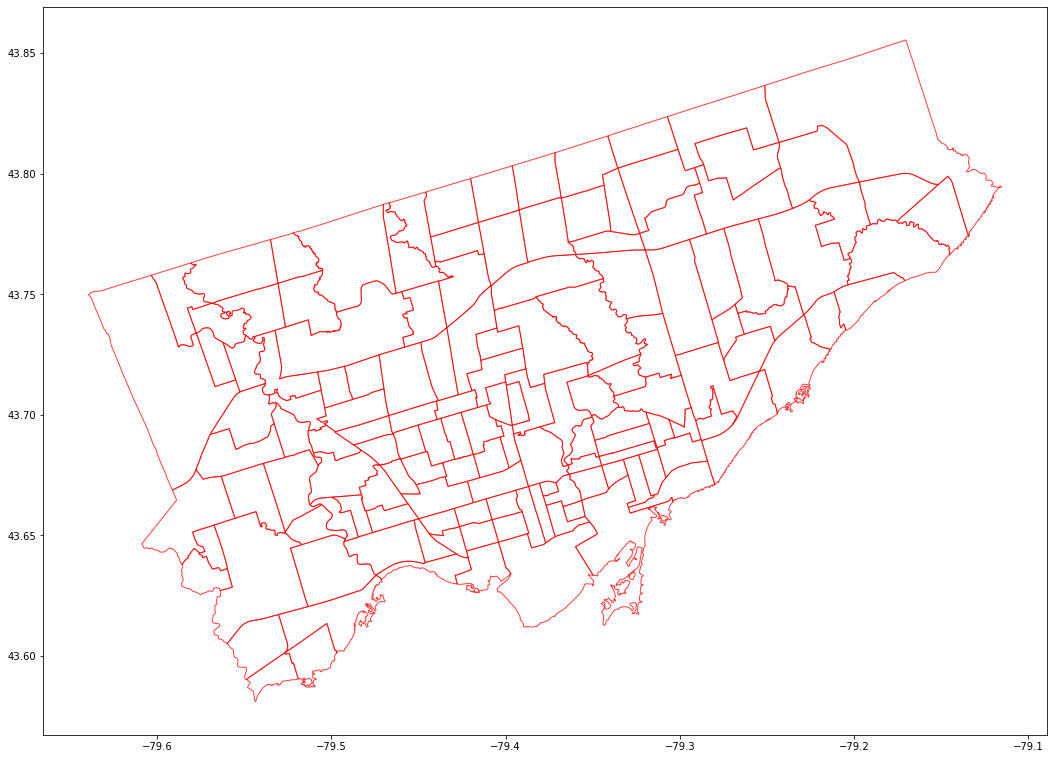

In [92]:
# plot neighbourhood boundaries
print(tor_nbs.geometry.crs)
print(tor_nbs.total_bounds)
ax = tor_nbs.plot(figsize=(18,14), 
                  edgecolor='red', 
                  facecolor='none', 
                  linewidth=1, 
                  alpha=0.75)

epsg:4326
[-79.6392252   43.58709189 -79.12306224  43.85375245]


<AxesSubplot:>

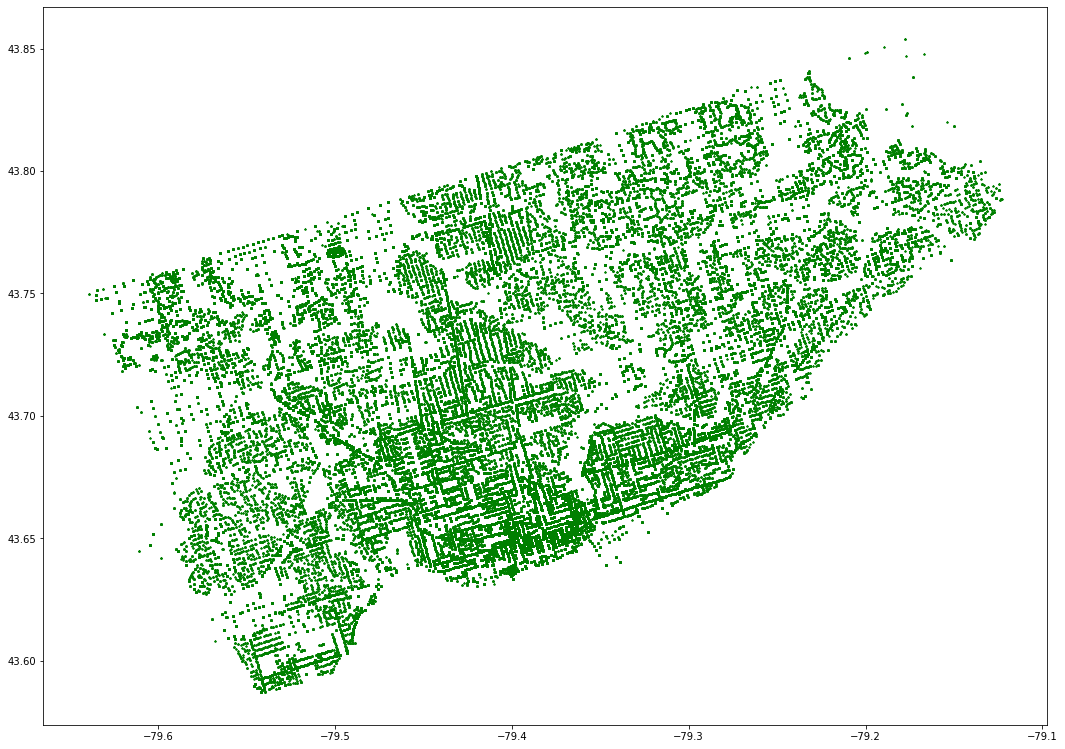

In [93]:
# plot crime
print(crime.geometry.crs)
print(crime.total_bounds)
crime.plot(figsize=(18,14), marker='*', color='green', markersize=3)

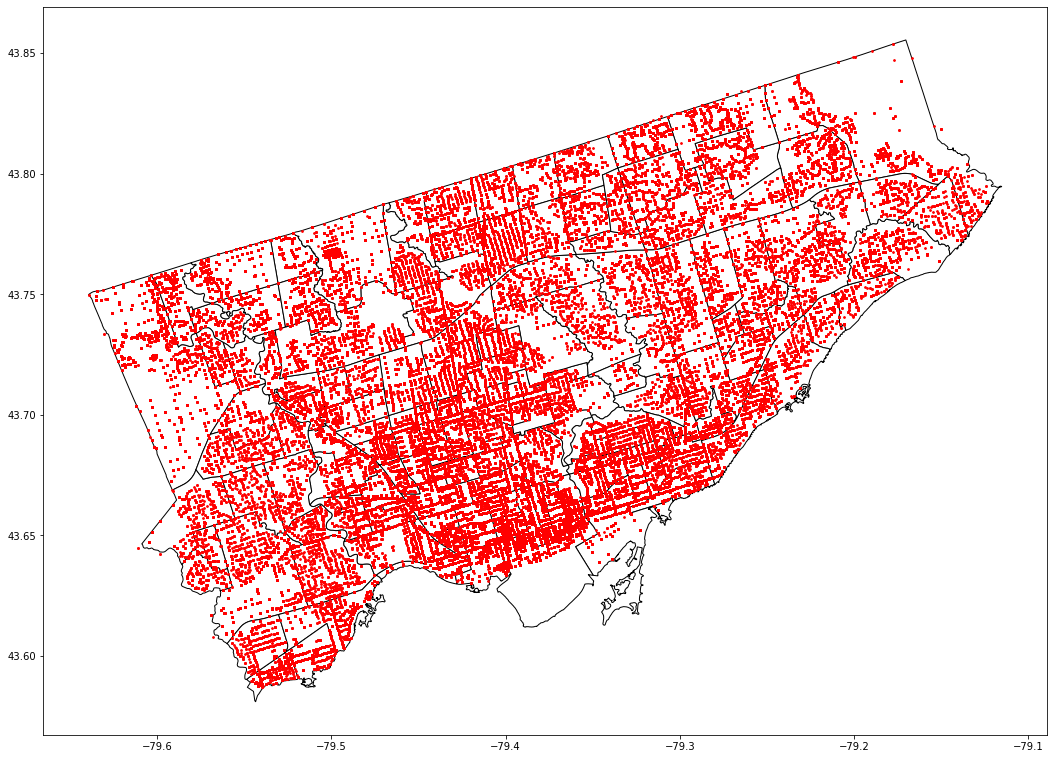

In [94]:
# plot neighbourhoods ...
base = tor_nbs.plot(figsize=(18,14), color='white', edgecolor='black')

# ... with crime
crime.plot(ax=base, figsize=(18,14), marker='o', color='red', markersize=3);

In [95]:
# this looks good!
# NOTE - it appears that some dots along the edges are outside toronto
    # HOWEVER - documentation notes crime locations moved to closest intersection to maintain annonimity
    # AS A RESULT - All included points have been verified as within an identified Toronto Neighbourhood, but may not appear so visually